In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from IPython.display import Image

In [2]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [3]:
DATASET_PATH = './real-estate-price-prediction-moscow/train.csv'
PREPARED_DATASET_PATH = './real-estate-price-prediction-moscow/prepared_data.csv'

REPORTS_FILE_PATH = './reports/'
SCALER_FILE_PATH = './models/scaler.pkl'
MODEL_FILE_PATH = './models/model.pkl'

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df



In [5]:
df = pd.read_csv(DATASET_PATH, sep=',')
df = reduce_mem_usage(df)
df.head()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750


Описание датасета

id - идентификационный номер квартиры<br/>
DistrictId - идентификационный номер района<br/>
Rooms - количество комнат<br/>
Square - площадь<br/>
LifeSquare - жилая площадь<br/>
KitchenSquare - площадь кухни<br/>
Floor - этаж<br/>
HouseFloor - количество этажей в доме<br/>
HouseYear - год постройки дома<br/>
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности<br/>
Social_1, Social_2, Social_3 - социальные показатели местности<br/>
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья<br/>
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров<br/>
Price - цена квартиры (Целевая переменная)<br/>

Первичные гипотезы по уменьшению количества признаков:</br>
(выводы с первого осмотра Датафрейма)</br>

1) DistrictID - маркировочная велична не имеющая, количественной и географической значимости, вероятно нужно выбросить признак
(Предварительно нужно еще раз посмотреть на него)

2)Square, lifesquare, kitchensquare - скорее всего сильно коррелируют и нужно объединить их во что-то одно

3)
Ecology_1, Ecology_2, Ecology_3</br>
Social_1, Social_2, Social_3</br>
Healthcare_1, Helthcare_2</br>
Shops_1, Shops_2</br>

Каждую группу однородных признаков скорее всего надо будет привести к одному признаку для каждой групп
#### Осмотр данных (EDA)

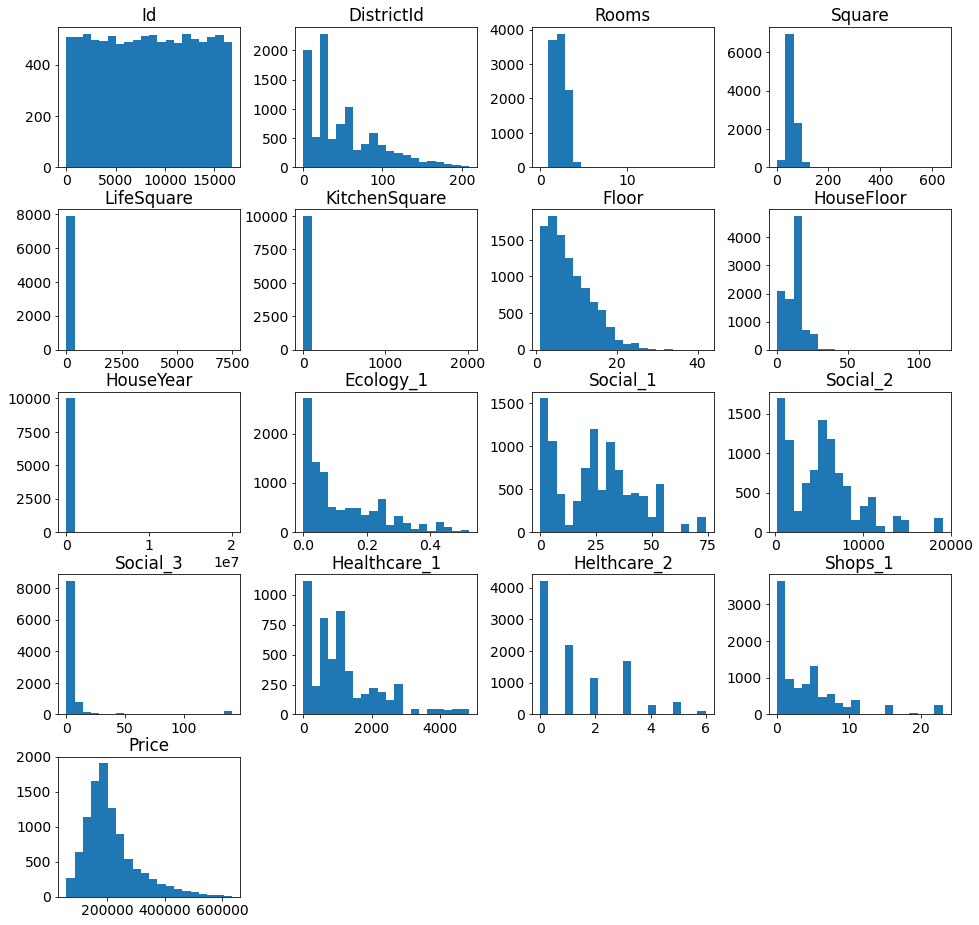

In [6]:
df.hist(figsize=(16,16), bins=20, grid=False);


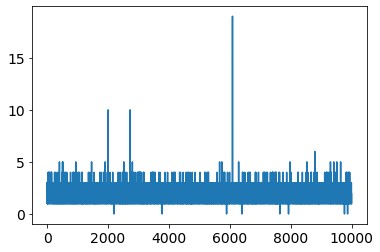

In [7]:
plt.plot(df['Rooms'])
# Посмотрев на данные понятно что все что больше 6ти комнат - выбросы.
# Абсолютно неадыкватные данные 3 объекта таких

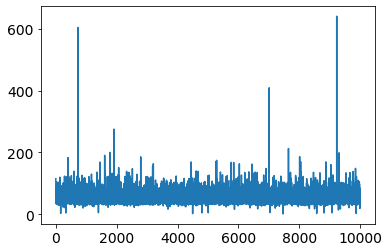

In [8]:
plt.plot(df['Square'])
# Площадь больше 276 квадратов явно выбросы, явно неадыкватные соотнешния цены и площади

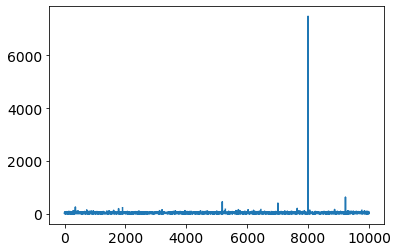

In [9]:
plt.plot(df['LifeSquare'])
# Объект с id 8000 явно выброс (>640)

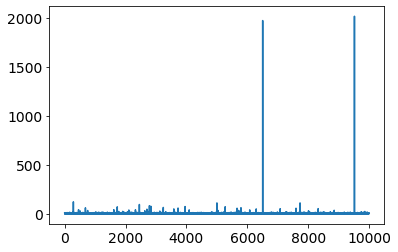

In [10]:
plt.plot(df['KitchenSquare'])

In [11]:
df_rooms_sample = pd.DataFrame(df, columns=['Rooms', 'Square','LifeSquare','KitchenSquare', 'Price'])
df_rooms_sample.nlargest(10, 'Rooms')

,Rooms,Square,LifeSquare,KitchenSquare,Price
6088,19.0,42.006046,21.779287,7.0,78364.617188
2004,10.0,59.056976,36.223072,10.0,317265.312500
2728,10.0,60.871265,38.420681,10.0,172329.265625
8794,6.0,59.414333,38.702244,6.0,229661.968750
403,5.0,183.382278,100.985504,15.0,622888.812500
505,5.0,112.135521,79.795448,10.0,471833.781250
511,5.0,124.933289,81.122368,30.0,271919.875000
940,5.0,117.855972,76.561317,9.0,608674.125000
1459,5.0,121.577423,114.913841,1.0,455446.406250
1906,5.0,275.645294,233.949310,26.0,455264.875000


In [12]:
df_rooms_sample.nlargest(10, 'Square')

,Rooms,Square,LifeSquare,KitchenSquare,Price
9229,2.0,641.065186,638.163208,10.0,133529.687500
726,2.0,604.705994,NaN,1.0,187717.250000
7010,1.0,409.425171,410.639740,10.0,90470.429688
1906,5.0,275.645294,233.949310,26.0,455264.875000
7644,0.0,212.932358,211.231125,0.0,302211.250000
1776,4.0,200.334534,201.627365,25.0,528560.500000
9307,5.0,198.930176,123.139862,10.0,345665.218750
1606,3.0,190.857681,107.376167,19.0,338644.062500
8011,4.0,186.692596,87.487083,32.0,423443.468750
2790,4.0,185.906403,84.830078,31.0,340273.250000


In [13]:
df_rooms_sample.nlargest(10, 'LifeSquare')

,Rooms,Square,LifeSquare,KitchenSquare,Price
8000,3.0,81.694420,7480.592285,1.0,217357.500000
9229,2.0,641.065186,638.163208,10.0,133529.687500
5183,3.0,78.059334,461.463623,10.0,394253.312500
7010,1.0,409.425171,410.639740,10.0,90470.429688
357,2.0,48.449875,263.542023,5.0,141780.234375
1906,5.0,275.645294,233.949310,26.0,455264.875000
7644,0.0,212.932358,211.231125,0.0,302211.250000
1776,4.0,200.334534,201.627365,25.0,528560.500000
5283,1.0,174.649521,174.837082,15.0,232766.187500
8872,3.0,169.509933,170.713654,1.0,200800.671875


In [14]:
df_rooms_sample.nlargest(40, 'KitchenSquare')
# Пока будем считать что все что больше 125 - выбросы.
# Мне этот признак вообще не нравится, слишком большая площадь кухни по отношению к общей

,Rooms,Square,LifeSquare,KitchenSquare,Price
9520,1.0,47.100719,46.447960,2014.0,108337.484375
6505,1.0,32.276665,19.278395,1970.0,105539.554688
286,3.0,123.430069,125.806984,123.0,234194.843750
5002,3.0,114.734474,112.589081,112.0,315245.531250
7733,3.0,116.405693,113.109650,112.0,296165.937500
2454,3.0,97.490677,99.323555,96.0,445074.968750
2785,1.0,38.220257,18.716856,84.0,99079.960938
2831,2.0,79.810532,79.578964,78.0,438708.718750
3956,3.0,78.445679,47.146755,75.0,290354.468750
5273,1.0,38.071693,19.723547,73.0,160488.031250


In [15]:
# создаем целевой Series для графиков зависимостей
target = pd.Series(df['Price'])
target

0       305018.875000
1       177734.546875
2       282078.718750
3       168106.000000
4       343995.093750
            ...      
9995    119367.453125
9996    199715.156250
9997    165953.906250
9998    171842.406250
9999    177685.625000
Name: Price, Length: 10000, dtype: float32

Строим зависимости различных признаков от целевой переменной чтобы посмотреть поведение

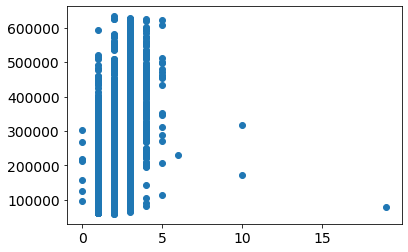

In [16]:
plt.scatter(df['Rooms'], target)

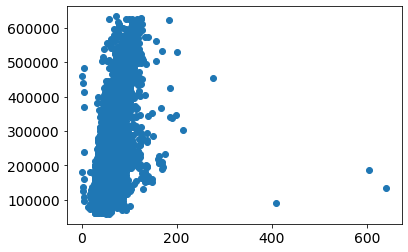

In [17]:
plt.scatter(df['Square'], target)

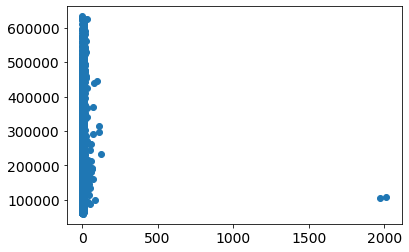

In [18]:
plt.scatter(df['KitchenSquare'], target)

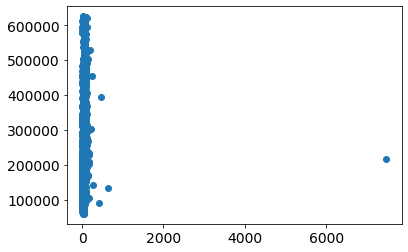

In [19]:
plt.scatter(df['LifeSquare'], target)


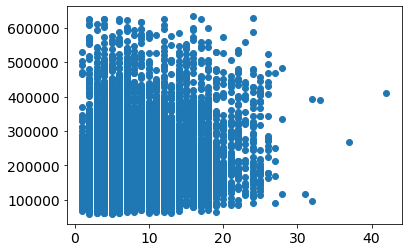

In [20]:
plt.scatter(df['Floor'], target)



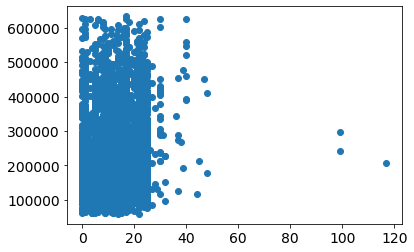

In [21]:
plt.scatter(df['HouseFloor'], target)
# Этажность дома выше 90 явно выбросы, остальные признаки сопоставимы по отношению к признаку этажа

dtype('int32')

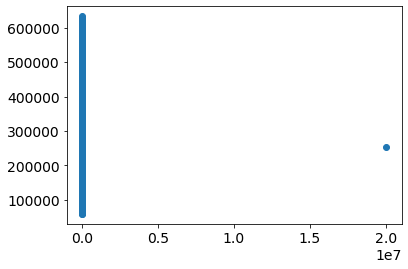

In [22]:
plt.scatter(df['HouseYear'], target)
df['HouseYear'].dtypes

In [23]:
houseYear = pd.Series(df['HouseYear'])
houseYear.nlargest(5)
#Дома больше 2020 года выбросные

9163    20052011
8828        4968
1004        2020
1077        2020
1976        2020
Name: HouseYear, dtype: int32

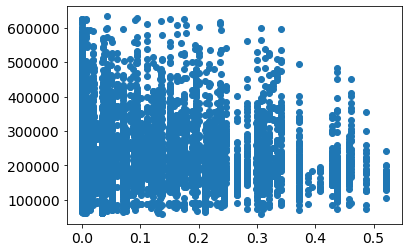

In [24]:
plt.scatter(df['Ecology_1'], target)



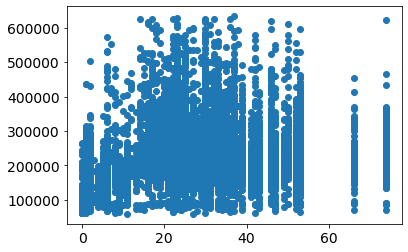

In [25]:
plt.scatter(df['Social_1'], target)



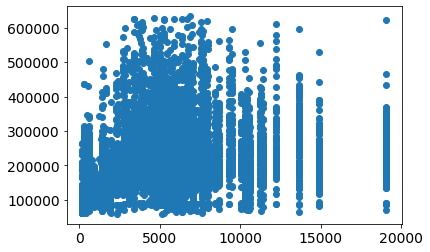

In [26]:
plt.scatter(df['Social_2'], target)



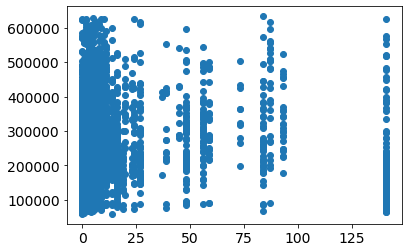

In [27]:
plt.scatter(df['Social_3'], target)

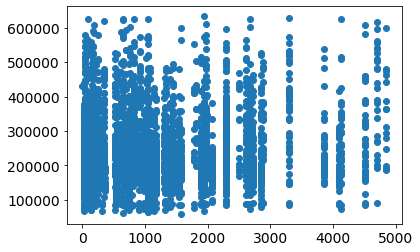

In [28]:
plt.scatter(df['Healthcare_1'], target)



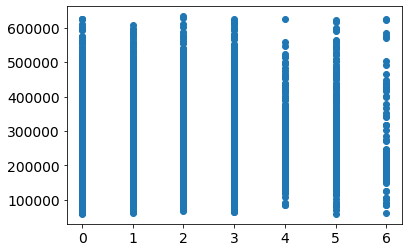

In [29]:
plt.scatter(df['Helthcare_2'], target)


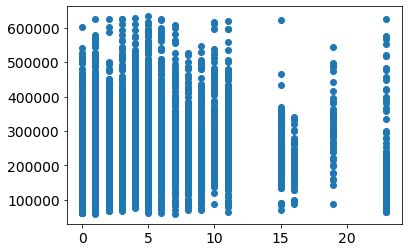

In [30]:
plt.scatter(df['Shops_1'], target)

In [31]:
df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

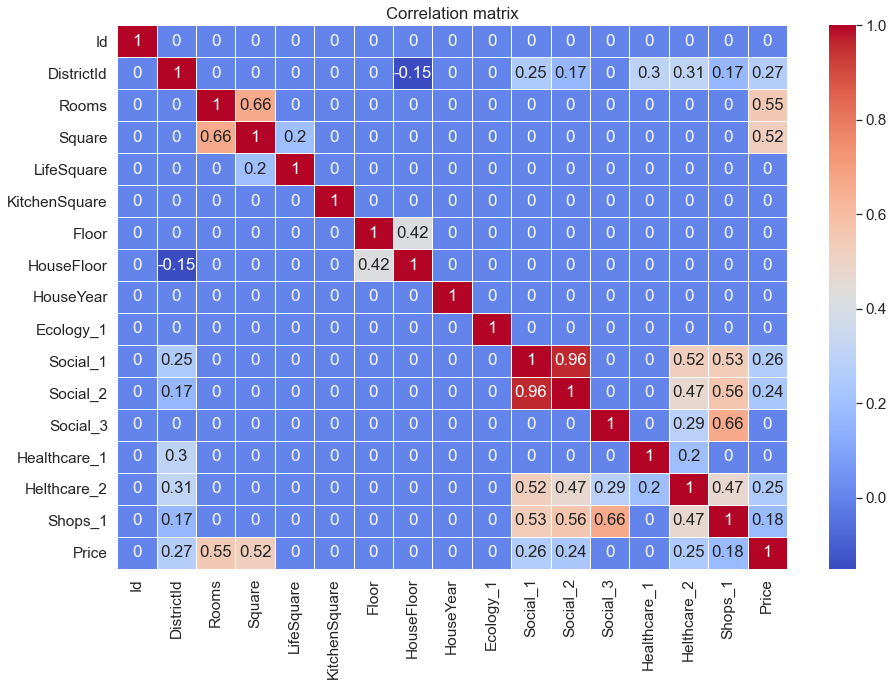

In [33]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.15] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [34]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Выводы:</br>
1) Выбросы удаляем из данных<br/>
2) Признак комнат > 6 - выбросы<br/>
3) Sqare > 277 - выбросы<br/>
4) LifeSqare > 640 - выбросы<br/>
5) KitchenSquare > 125 - выбросы<br/>
6) HouseFloor > 90 - выбросы<br/>
7) HouseYear > 2020 - выбросы<br/>
8) LifeSqare, Healthcare_1 - имеют много пропусков надо обработать<br/>
9) LifeSqare обработаю следующим образом: От площади отниму 10, услвная величина проходит по всем данным<br/>
10) Healtcare_1 - скорее всего надо заполнить средними значениями признака.<br/>
11) По возможности постараться Healthcare_1 и Healthcare_2 понизить в размерности.<br/>
12) Есть три категориальных переменных Ecology_2, Ecology_3, Shops_2<br/>
13) Матрица корреляции говорит о том что Social_1, Social_2 очень сильно коррелируют - их надо объединять в один<br/>

Поработаем с категориальными признаками

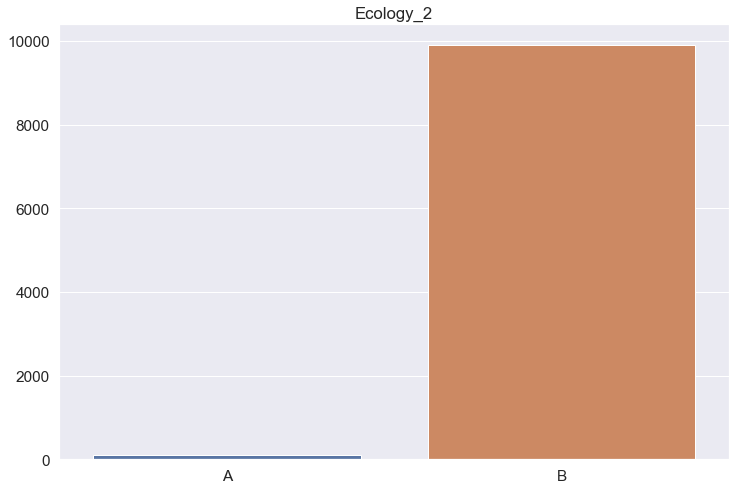

In [35]:
# Функция построения гистограммы категориальных признаков
def counts_bar(data_frame, feature_name):
    counts = data_frame[feature_name].value_counts()
    plt.figure(figsize=(12,8))
    plt.title(feature_name)
    sns.barplot(counts.index, counts.values)
    plt.show()

counts_bar(df, 'Ecology_2')

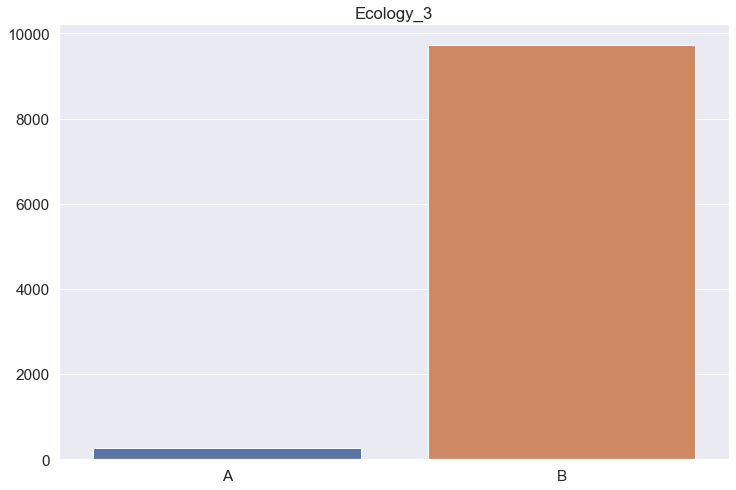

In [36]:
counts_bar(df, 'Ecology_3')

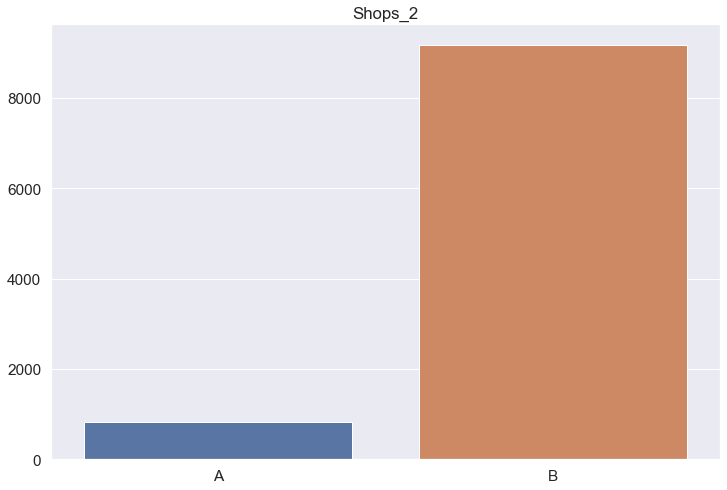

In [37]:
counts_bar(df, 'Shops_2')

In [38]:
df['Shops_2'].dtype

CategoricalDtype(categories=['A', 'B'], ordered=False)

In [39]:
# Создание числовых признаков для категориальных переменных
def class_to_int(data_frame, feature):
    if data_frame[feature].dtype == 'category':
        data_frame[feature + '_binary'] = 0
        data_frame.loc[data_frame[feature] == 'A', feature + '_binary'] = 1
        data_frame.loc[data_frame[feature] == 'B', feature + '_binary'] = 0
    else:
        print('Функция работает только с категориальными переменными в рамках датасета')

class_to_int(df, 'Ecology_2')
class_to_int(df, 'Ecology_3')
class_to_int(df, 'Shops_2')
df = df.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1)

In [40]:
df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_binary,Ecology_3_binary,Shops_2_binary
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0,305018.875000,0,0,0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0,177734.546875,0,0,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1,282078.718750,0,0,0
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1,168106.000000,0,0,0
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6,343995.093750,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,52,10311,6,NaN,1,9,119367.453125,0,0,0
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,2,629,1,NaN,0,0,199715.156250,0,0,1
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,20,4386,14,NaN,1,5,165953.906250,0,0,0
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,47,8004,3,125.0,3,5,171842.406250,0,0,0


In [41]:
df.dtypes



Id                    int16
DistrictId            int16
Rooms               float32
Square              float32
LifeSquare          float32
KitchenSquare       float32
Floor                  int8
HouseFloor          float32
HouseYear             int32
Ecology_1           float32
Social_1               int8
Social_2              int16
Social_3              int16
Healthcare_1        float32
Helthcare_2            int8
Shops_1                int8
Price               float32
Ecology_2_binary      int64
Ecology_3_binary      int64
Shops_2_binary        int64
dtype: object